In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model, backend as K

from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
import cv2

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def dice_coefficient(y_true, y_pred):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1)

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return intersection / (union + tf.keras.backend.epsilon())

def unet_model(input_size=(256, 256, 3)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    # Bottleneck
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    
    # Decoder
    up1 = layers.UpSampling2D(size=(2, 2))(conv3)
    up1 = layers.concatenate([up1, conv2], axis=-1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(up1)
    conv4 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv4)
    
    up2 = layers.UpSampling2D(size=(2, 2))(conv4)
    up2 = layers.concatenate([up2, conv1], axis=-1)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(up2)
    conv5 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv5)
    
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv5)  # Sigmoid for binary classification
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define loss function
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)

def measure_of_enhancement(img, k=8):
    """
    Calculates the Measure of Enhancement (EME) for the given image.
    Higher EME indicates better contrast.
    :param img: Input image in RGB format.
    :param k: Tile size (default is 8).
    :return: EME value
    """
    height, width, _ = img.shape
    eme = 0.0
    for i in range(0, height, k):
        for j in range(0, width, k):
            tile = img[i:i+k, j:j+k]
            min_val = np.min(tile)
            max_val = np.max(tile)
            if min_val > 0:
                eme += 20 * np.log10(max_val / min_val)
    eme /= ((height // k) * (width // k))
    return eme

def enhance_img(img):
    # Step 1: Apply median filter with a 3x3 kernel
    img = cv2.medianBlur(img.astype(np.uint8), ksize=3)

    # Step 2: Convert to LAB color space
    lab_img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab_img)

    # Step 3: Apply CLAHE on the Luminosity (L) channel with 8x8 tile grid
    clahe = cv2.createCLAHE(clipLimit=6.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Step 4: Merge CLAHE enhanced L with original A and B channels
    lab_img = cv2.merge((l, a, b))

    # Step 5: Convert back to RGB color space
    enhanced_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2RGB)
    
    return enhanced_img

def load_data(image_dir, mask_dir, image_size):
    images = []
    masks = []
    
    # Loop through all image files
    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            # Get the base name (e.g., 'H0001' from 'H0001.jpg')
            base_name = os.path.splitext(filename)[0]
            
            # Construct the corresponding mask filename
            mask_filename = f"{base_name}.tif"
            
            # Check if the corresponding mask exists
            img_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, mask_filename)
        
            if os.path.exists(mask_path):
                # Load and resize the image and mask
                img = load_img(img_path, target_size=image_size)
                mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
                
                # Enhance the image
                img = img_to_array(img)
                img = enhance_img(img)
                
                print(f"Enhanced image {filename} with EME: {measure_of_enhancement(img)}")
                
                # Convert to numpy arrays
                img_array = img / 255.0  # Image is normalized
                mask_array = img_to_array(mask) / 255.0  # Mask is binary
                
                # Append the arrays to the lists
                images.append(img_array)
                masks.append(mask_array)
            else:
                print(f"Skipping {filename} as no corresponding mask was found.")
        print()
    
    # Convert the lists to numpy arrays
    return np.array(images), np.array(masks)

In [4]:
# Compile model
model = unet_model()
model.compile(optimizer='adam', 
              loss=combined_loss, 
              metrics=['accuracy', dice_coefficient, iou_metric])

Metal device set to: Apple M2 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-10-31 22:42:28.113809: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-31 22:42:28.113999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# Directories for images and masks
image_dir = "path/to/DDR/lesion_segmentation/all/image"
mask_dir = "path/to/DDR/lesion_segmentation/all/label/HE"

# Image size (height, width, channels)
image_size = (256, 256)

all_images, all_masks = load_data(image_dir, mask_dir, image_size)

# Split into training and test sets (80% train, 20% test)
train_images, test_images, train_masks, test_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=42
)

# split train set into training and validation sets (90% train, 10% validation)
train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)

Enhanced image 007-6573-400.jpg with EME: 7.3849506555311875

Enhanced image 007-4263-200.jpg with EME: 7.5769601181104

Enhanced image 007-4273-200.jpg with EME: 7.682248447807628

Enhanced image 007-5331-300.jpg with EME: 6.651639647648891

Enhanced image 007-7111-400.jpg with EME: 12.165605768798834

Enhanced image 007-4105-200.jpg with EME: 11.01540775812044

Enhanced image 007-2280-100.jpg with EME: 5.509682186437654

Enhanced image 007-6615-400.jpg with EME: 11.127602779657625

Enhanced image 007-3873-200.jpg with EME: 6.060409227624627

Enhanced image 007-4691-200.jpg with EME: 10.940633100317415

Enhanced image 007-3386-200.jpg with EME: 13.268649206806698

Enhanced image 007-3396-200.jpg with EME: 5.7865016791546715

Enhanced image 007-2768-100.jpg with EME: 7.737467508298144

Enhanced image 007-4585-200.jpg with EME: 12.070765154674831

Enhanced image 007-2600-100.jpg with EME: 13.481919250004422

Enhanced image 007-1774-100.jpg with EME: 8.332512165300917

Enhanced image 007

In [6]:
len(all_images), len(all_masks)

(757, 757)

In [7]:
history = model.fit(train_images, train_masks, epochs=75,
                    batch_size=16, verbose=1, steps_per_epoch=len(train_images) // 16,
                    validation_data=(val_images, val_masks))

Epoch 1/75


2024-10-31 22:42:58.438552: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-10-31 22:42:58.874187: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - ETA: 0s - loss: 1.0915 - accuracy: 0.9673 - dice_coefficient: 0.0051 - iou_metric: 7.2108e-05

2024-10-31 22:43:39.074377: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


34/34 [==============================] - 43s 1s/step - loss: 1.0915 - accuracy: 0.9673 - dice_coefficient: 0.0051 - iou_metric: 7.2108e-05 - val_loss: 1.0175 - val_accuracy: 0.9955 - val_dice_coefficient: 0.0087 - val_iou_metric: 0.0000e+00
Epoch 2/75
34/34 [==============================] - 39s 1s/step - loss: 1.0155 - accuracy: 0.9964 - dice_coefficient: 0.0098 - iou_metric: 0.0000e+00 - val_loss: 1.0146 - val_accuracy: 0.9955 - val_dice_coefficient: 0.0118 - val_iou_metric: 0.0000e+00
Epoch 3/75
34/34 [==============================] - 39s 1s/step - loss: 1.0045 - accuracy: 0.9964 - dice_coefficient: 0.0195 - iou_metric: 0.0000e+00 - val_loss: 1.0062 - val_accuracy: 0.9955 - val_dice_coefficient: 0.0218 - val_iou_metric: 0.0000e+00
Epoch 4/75
34/34 [==============================] - 39s 1s/step - loss: 0.9873 - accuracy: 0.9964 - dice_coefficient: 0.0378 - iou_metric: 0.0000e+00 - val_loss: 1.0114 - val_accuracy: 0.9955 - val_dice_coefficient: 0.0322 - val_iou_metric: 0.0000e+00
Epo

In [8]:
scores = model.evaluate(val_images, val_masks)
print("Validation Loss: %.2f" % scores[0])
print("Validation Accuracy: %.2f%%" % (scores[1] * 100))
print("Validation IoU: %.2f%%" % (scores[2] * 100))
print("Validation Dice: %.2f%%" % (scores[3] * 100))

2/2 [==============================] - 2s 1s/step - loss: 0.7843 - accuracy: 0.9958 - dice_coefficient: 0.2655 - iou_metric: 0.1536
Validation Loss: 0.78
Validation Accuracy: 99.58%
Validation IoU: 26.55%
Validation Dice: 15.36%


In [9]:
scores = model.evaluate(test_images, test_masks)
print("Test Loss: %.2f" % scores[0])
print("Test Accuracy: %.2f%%" % (scores[1] * 100))
print("Test IoU: %.2f%%" % (scores[2] * 100))
print("Test Dice: %.2f%%" % (scores[3] * 100))

5/5 [==============================] - 5s 882ms/step - loss: 0.6857 - accuracy: 0.9973 - dice_coefficient: 0.3414 - iou_metric: 0.2070
Test Loss: 0.69
Test Accuracy: 99.73%
Test IoU: 34.14%
Test Dice: 20.70%


## Visualise

1/1 [==============================] - 0s 59ms/step


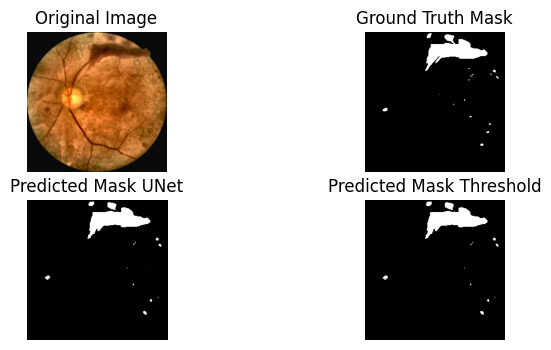

In [16]:
image = all_images[234]  # Original test image
true_mask = all_masks[234]  # Ground truth mask

pred_mask_unet = model.predict(np.expand_dims(image, axis=0))  # Predict mask
pred_mask_unet_binary = (pred_mask_unet > 0.5).astype(int)  # Convert to binary

# pred_mask_resnet = model_resnet.predict(np.expand_dims(image, axis=0))  # Predict mask
# pred_mask_resnet_binary = (pred_mask_resnet > 0.5).astype(int)  # Convert to binary

# Function to visualize image, ground truth mask, and predicted mask
plt.figure(figsize=(8, 4))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Ground truth mask
plt.subplot(2, 2, 2)
plt.imshow(true_mask.squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 3)
plt.imshow(pred_mask_unet.squeeze(), cmap='gray')
plt.title("Predicted Mask UNet")
plt.axis('off')

# Predicted mask
plt.subplot(2, 2, 4)
plt.imshow(pred_mask_unet_binary.squeeze(), cmap='gray')
plt.title("Predicted Mask Threshold")
plt.axis('off')

plt.show()

## Save

In [11]:
# Save the model
model_json = model.to_json()
with open('../models_segmentation/HE.json', 'w') as json_file:
    json_file.write(model_json)

# Saving the model and weights
model.save_weights('../models_segmentation/HE.weights.h5')